error: XDG_RUNTIME_DIR is invalid or not set in the environment.


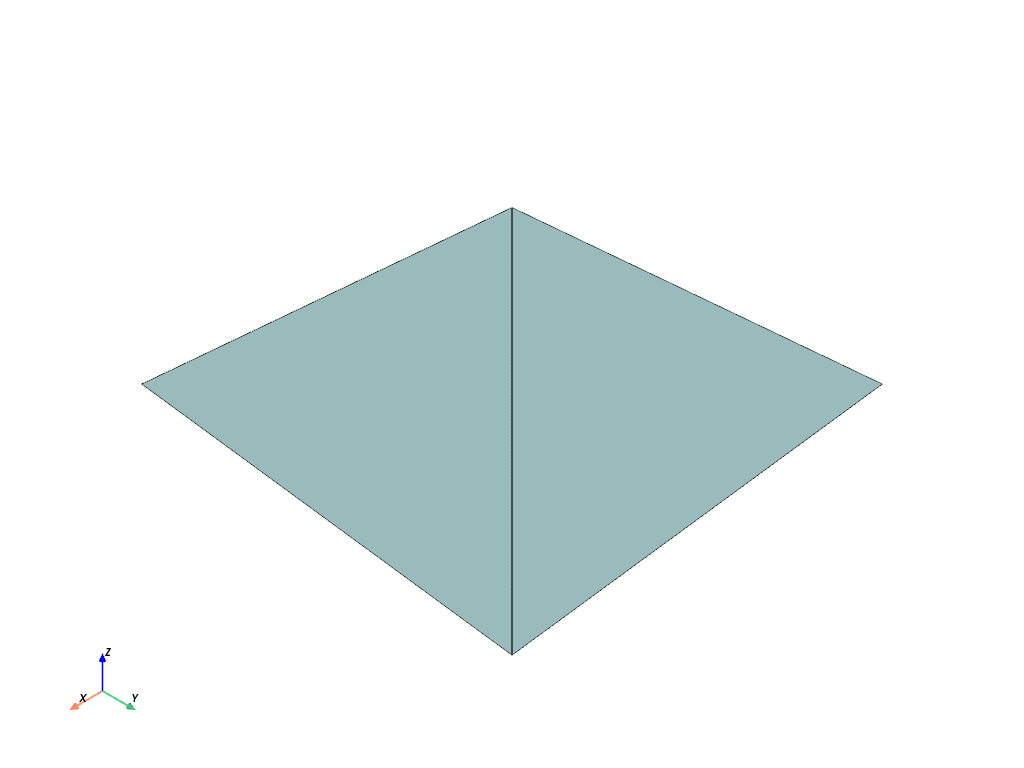

In [10]:
import numpy as np
import basix.ufl
import ufl
import dolfinx
from mpi4py import MPI
import pyvista

tri_points = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float64)
triangles = np.array([[0, 1, 3], [0, 2, 3]], dtype=np.int64)
ufl_tri = ufl.Mesh(basix.ufl.element("Lagrange", "triangle", 1, shape=(2,)))
tri_mesh = dolfinx.mesh.create_mesh(MPI.COMM_WORLD, triangles, tri_points, ufl_tri)
_tri = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(tri_mesh))

pyvista.start_xvfb(1)
plotter = pyvista.Plotter(shape=(1, 1))
plotter.subplot(0, 0)
plotter.show_axes()
_quad = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(quad_mesh))
plotter.add_mesh(_tri, show_edges=True)
plotter.show()

In [22]:
import math

def diameter_at_x(geo, x):

    if x==0:
        return geo[0][1]

    for i in range(len(geo)):
        if x<geo[i][0]:
            break

    x1=geo[i-1][0]
    y1=geo[i-1][1]
    x2=geo[i][0]
    y2=geo[i][1]

    ydiff=(y2-y1)/2
    xdiff=(x2-x1)

    winkel=math.atan(ydiff/xdiff)
    y=math.tan(winkel)*(x-x1)*2+y1
    return y

def segmentize_geo(geo, resolution):
    xs = [g[0] for g in geo]
    for x in range(0, xs[-1], resolution):
        if x not in xs:
            xs.append(x)
    xs = sorted(xs)

    new_geo = []
    for x in xs:
        y = diameter_at_x(geo, x)
        new_geo.append([x,y])

    return new_geo

geo = [[0,32], [800,32], [900,38], [970,42], [1050, 40], [1180, 48], [1350, 60], [1390, 68], [1500, 72]]
geo = segmentize_geo(geo, 10)


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


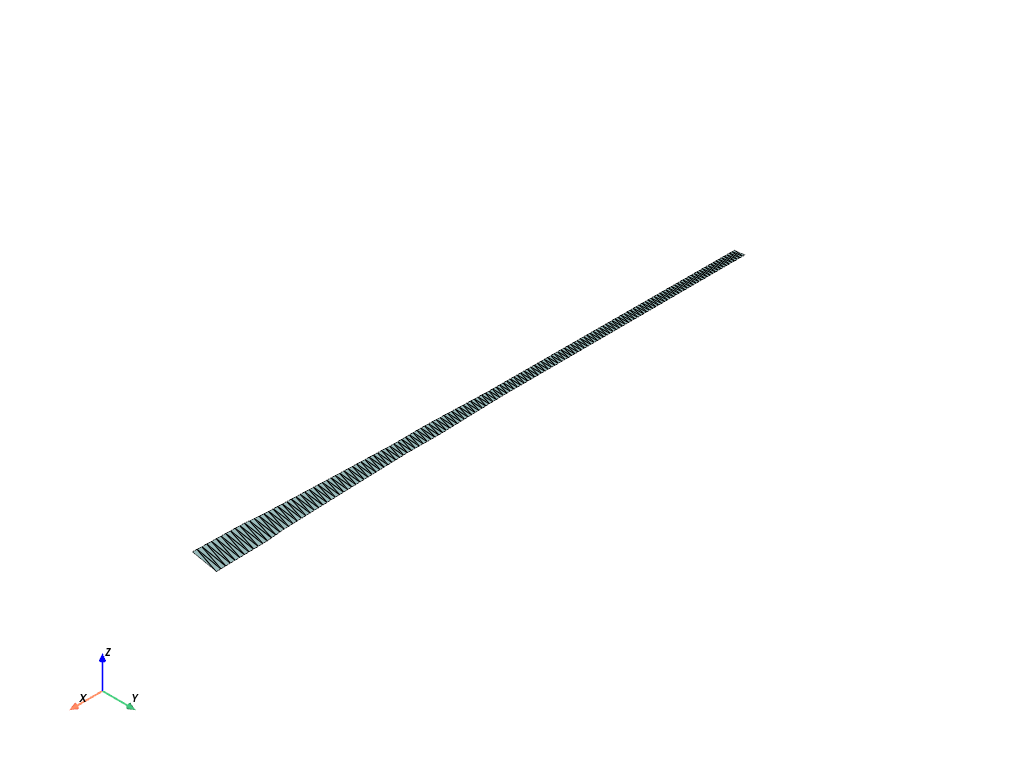

In [24]:
tri_points = []
triangles = []

for g in geo:
    p1 = g.copy()
    p1[0] /= 1000
    p1[1]/=1000*2
    p2 = g.copy()
    p2[0] /= 1000
    p2[1]/=-1000*2

    tri_points.append(p1)
    tri_points.append(p2)

    i = len(tri_points)
    if len(tri_points)<3:
        continue

    triangles.append([i-4, i-3, i-2])
    triangles.append([i-3, i-2, i-1])

ufl_tri = ufl.Mesh(basix.ufl.element("Lagrange", "triangle", 1, shape=(2,)))
tri_mesh = dolfinx.mesh.create_mesh(MPI.COMM_WORLD, triangles, tri_points, ufl_tri)
_tri = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(tri_mesh))

pyvista.start_xvfb(1)
plotter = pyvista.Plotter(shape=(1, 1))
plotter.subplot(0, 0)
plotter.show_axes()
plotter.add_mesh(_tri, show_edges=True)
plotter.show()

This is all the input we need to a DOLFINx mesh


error: XDG_RUNTIME_DIR is invalid or not set in the environment.


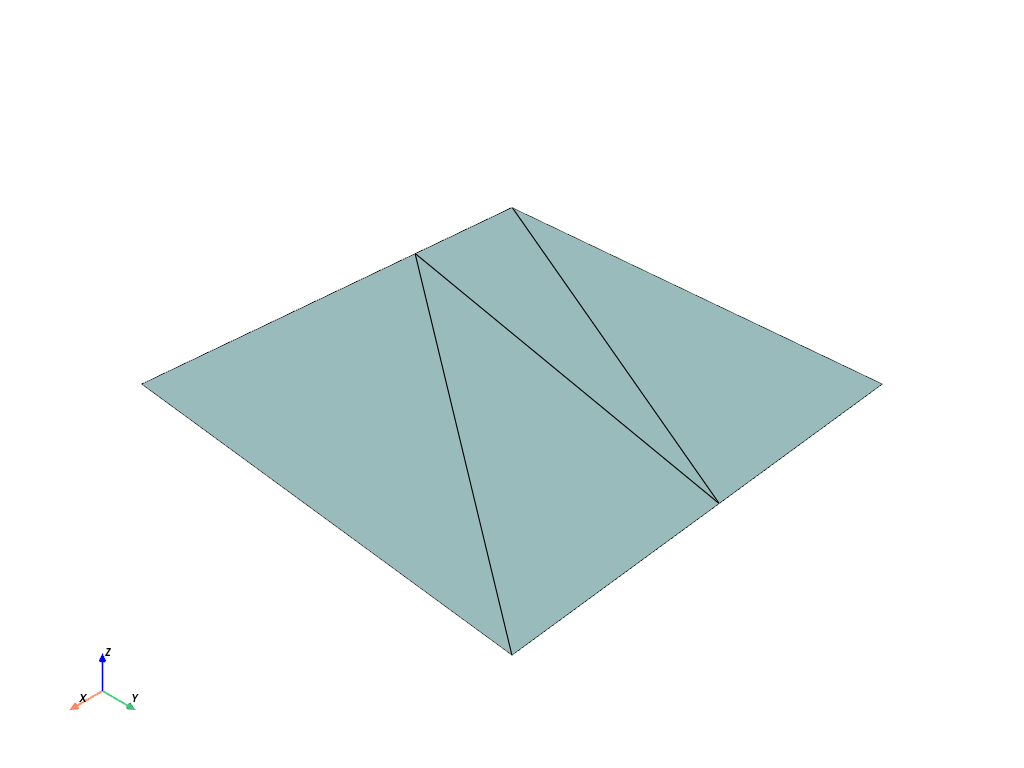

The only input to this function we have not covered so far is the `MPI.COMM_WORLD`, which is an MPI communicator.

### MPI Communication

When we run a python code with `python3 name_of_file.py`. We execute python on a single process on the computer. However, if we launch the code with `mpirun -n N python3 name_of_file.py`, we execute the code on `N` processes at the same time. The `MPI.COMM_WORLD` is the communicator among the `N` processes, which can be used to send and receive data. If we use `MPI.COMM_SELF`, the communicator will not communicate with other processes.
When we run in serial, `MPI.COMM_WORLD` is equivalent to `MPI.COMM_SELF`.

Two important values in the MPI-communicator is its `rank` and `size`.
If we run this in serial on either of the communicators above, we get


In [7]:
print(f"{MPI.COMM_WORLD.rank=} {MPI.COMM_WORLD.size=}")
print(f"{MPI.COMM_SELF.rank=} {MPI.COMM_SELF.size=}")

MPI.COMM_WORLD.rank=0 MPI.COMM_WORLD.size=1
MPI.COMM_SELF.rank=0 MPI.COMM_SELF.size=1


In jupyter noteboooks, we use [ipyparallel](https://ipyparallel.readthedocs.io/en/latest/) to start a cluster and connect to two processes, which we can execute commands on using the magic `%%px` at the top of each cell. See [%%px Cell magic](https://ipyparallel.readthedocs.io/en/latest/tutorial/magics.html#px-cell-magic) for more details.

```{note}
When starting a cluster, we do not carry ower any modules or variables from the previously executed code in the script.
```


In [ ]:
import ipyparallel as ipp

cluster = ipp.Cluster(engines="mpi", n=2)
rc = cluster.start_and_connect_sync()

Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


INFO:ipyparallel.cluster.cluster.1679244433-r03j:Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>


  0%|          | 0/2 [00:00<?, ?engine/s]

Next, we import `mpi4py` on the two engines and check the rank and size of the two processes.


In [ ]:
%%px
from mpi4py import MPI as MPIpx
import numpy as np
import ufl
import dolfinx
import basix.ufl

print(f"{MPIpx.COMM_WORLD.rank=} {MPIpx.COMM_WORLD.size=}")

[stdout:1] MPIpx.COMM_WORLD.rank=1 MPIpx.COMM_WORLD.size=2


[stdout:0] MPIpx.COMM_WORLD.rank=0 MPIpx.COMM_WORLD.size=2


Next, we want to create the triangle mesh, distributed over the two processes.
We do this by sending in the points and cells for the mesh in one of two ways:

**1. Send all points and cells on one process**


In [ ]:
%%px
if MPIpx.COMM_WORLD.rank == 0:
    tri_points = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float64)
    triangles = np.array([[0, 1, 3], [0, 2, 3]], dtype=np.int64)
else:
    tri_points = np.empty((0, 2), dtype=np.float64)
    triangles = np.empty((0, 3), dtype=np.int64)
ufl_tri = ufl.Mesh(basix.ufl.element("Lagrange", "triangle", 1, shape=(2,)))
tri_mesh = dolfinx.mesh.create_mesh(MPIpx.COMM_WORLD, triangles, tri_points, ufl_tri)
cell_index_map = tri_mesh.topology.index_map(tri_mesh.topology.dim)
print(
    f"Num cells local: {cell_index_map.size_local}\n Num cells global: {cell_index_map.size_global}"
)

[stdout:1] Num cells local: 1
 Num cells global: 2


[stdout:0] Num cells local: 1
 Num cells global: 2


In [ ]:
%%px
import pyvista

pyvista.start_xvfb(1)


def plot_mesh(mesh):
    mesh.topology.create_connectivity(1, mesh.topology.dim)
    mesh.topology.create_connectivity(1, 0)
    plotter = pyvista.Plotter(window_size=(500, 500))
    cell_map = mesh.topology.index_map(mesh.topology.dim)
    num_cells_local = cell_map.size_local
    if num_cells_local == 0:
        # Until https://github.com/FEniCS/dolfinx/pull/3696 is merged
        return
    _mesh = pyvista.UnstructuredGrid(
        *dolfinx.plot.vtk_mesh(
            mesh,
            dim=mesh.topology.dim,
            entities=np.arange(num_cells_local, dtype=np.int32),
        )
    )

    cell_label_idx = mesh.topology.index_map(mesh.topology.dim).local_to_global(
        np.arange(num_cells_local)
    )
    cell_labels = [f"Cell {i}" for i in cell_label_idx]
    plotter.add_point_labels(_mesh.cell_centers(), cell_labels, font_size=12)

    edge_map = mesh.topology.index_map(1)
    num_edges_local = edge_map.size_local + edge_map.num_ghosts
    if num_edges_local > 0:
        _edge_mesh = pyvista.UnstructuredGrid(
            *dolfinx.plot.vtk_mesh(
                mesh, dim=1, entities=np.arange(num_edges_local, dtype=np.int32)
            )
        )

    node_map = mesh.geometry.index_map()
    node_label_idx = node_map.local_to_global(
        np.arange(node_map.size_local + node_map.num_ghosts, dtype=np.int32)
    )
    node_labels = [f"Node {i}" for i in node_label_idx]
    plotter.add_point_labels(_mesh.points, node_labels, font_size=12)
    if _mesh.n_cells > 0:
        if num_edges_local > 0:
            plotter.add_mesh(_edge_mesh, style="wireframe", color="black", line_width=2)
        plotter.add_title(f"Rank: {mesh.comm.rank}")
        plotter.show_axes()
        plotter.show()

[output:1]

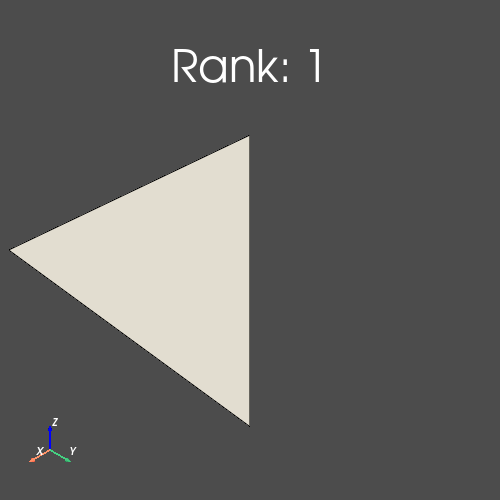

[output:0]

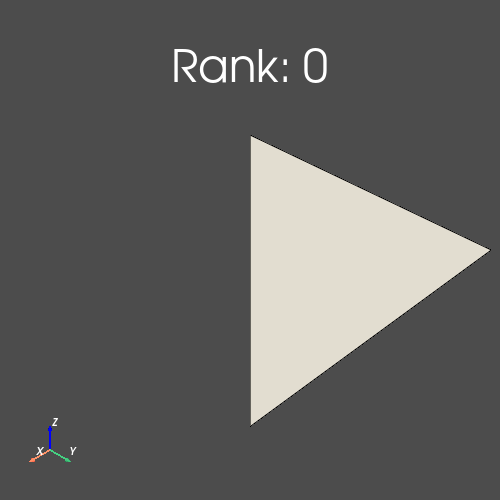

In [38]:
%%px
plot_mesh(tri_mesh)

From the output above, we see the distribution of cells on each process.

**2. Distribute input of points and cells**

For large meshes, reading in all points and cells on a single process would be a bottle-neck.
Therefore, we can read in the points and cells in a distributed fashion.
Note that if we do this it important to note that it is assumed that rank 0 has read in the first chunck of points and cells in a continuous fashion.


In [ ]:
%%px
if MPIpx.COMM_WORLD.rank == 0:
    quadrilaterals = np.empty((0, 4), dtype=np.int64)
    quad_points = np.array([[0, 0], [0.3, 0]], dtype=np.float64)
elif MPIpx.COMM_WORLD.rank == 1:
    quadrilaterals = np.array([[0, 1, 3, 4], [1, 2, 4, 5]], dtype=np.int64)
    quad_points = np.array([[1, 0], [0, 1], [0.5, 1], [1, 1]], dtype=np.float64)
else:
    quadrilaterals = np.empty((0, 4), dtype=np.int64)
    quad_points = np.empty((0, 2), dtype=np.float64)


ufl_quad = ufl.Mesh(basix.ufl.element("Lagrange", "quadrilateral", 1, shape=(2,)))
quad_mesh = dolfinx.mesh.create_mesh(
    MPIpx.COMM_WORLD, quadrilaterals, quad_points, ufl_quad
)
cell_index_map = quad_mesh.topology.index_map(quad_mesh.topology.dim)
print(
    f"Num cells local: {cell_index_map.size_local}\n Num cells global: {cell_index_map.size_global}"
)

[stdout:1] Num cells local: 1
 Num cells global: 2


[stdout:0] Num cells local: 1
 Num cells global: 2


[output:1]

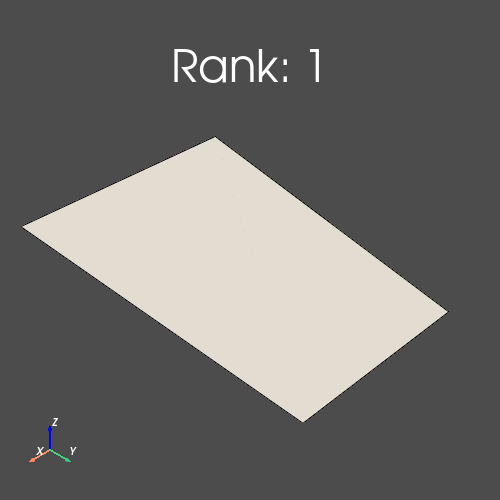

[output:0]

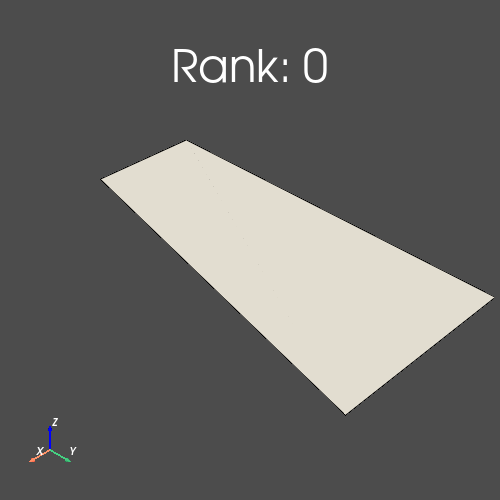

In [40]:
%%px
plot_mesh(quad_mesh)

### Usage of MPI.COMM_SELF

You might wonder, if we can use multiple processes, when would we ever use `MPI.COMM_SELF`?
There are many reasons for this. For instance, many simulations are too small to gain from parallelizing.
Then one could use `MPI.COMM_SELF` with multiple processes to run parameterized studies in parallel


In [ ]:
%%px
serial_points = np.array(
    [[0, 0], [0.3, 0], [1, 0], [0, 1], [0.5, 1], [1, 1]], dtype=np.float64
)
serial_quads = np.array([[0, 1, 3, 4], [1, 2, 4, 5]], dtype=np.int64)
serial_mesh = dolfinx.mesh.create_mesh(
    MPIpx.COMM_SELF, serial_quads, serial_points, ufl_quad
)
cell_index_map = serial_mesh.topology.index_map(serial_mesh.topology.dim)
print(
    f"Num cells local: {cell_index_map.size_local}\n Num cells global: {cell_index_map.size_global}"
)

[stdout:1] Num cells local: 2
 Num cells global: 2


[stdout:0] Num cells local: 2
 Num cells global: 2


[output:0]

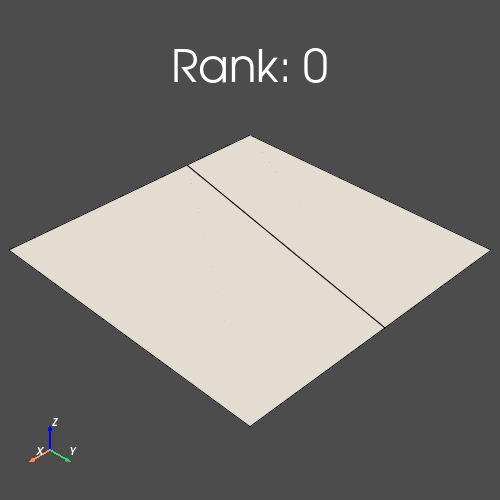

[output:1]

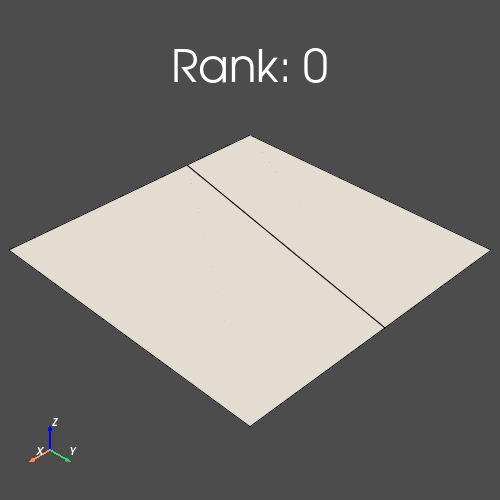

In [42]:
%%px
plot_mesh(serial_mesh)

## Mesh-partitioning

As we have seen above, we can send in data to mesh creation and get either a distributed mesh out, but how does it work?
Under the hood, what happens is that DOLFINx calls a graph-partitioning algorithm.
This algorithm is supplied from either from PT-Scotch{cite}`10.1016/j.parco.2007.12.001`, ParMETIS{cite}`10.1145/369028.369103` or KaHIP{cite}`10.1007/978-3-642-38527-8_16`, depending on what is available with your installation.

We can list the available partitioners with the following code:


In [ ]:
%%px
try:
    from dolfinx.graph import partitioner_scotch

    has_scotch = True
except ImportError:
    has_scotch = False
try:
    from dolfinx.graph import partitioner_kahip

    has_kahip = True
except ImportError:
    has_kahip = False
try:
    from dolfinx.graph import partitioner_parmetis

    has_parmetis = True
except ImportError:
    has_parmetis = False
print(f"{has_scotch=}  {has_kahip=} {has_parmetis=}")

[stdout:1] has_scotch=True  has_kahip=False has_parmetis=False


[stdout:0] has_scotch=True  has_kahip=False has_parmetis=False


Given any of these partitioners (we will from now on use Scotch), you can send them into create mesh by calling


In [ ]:
%%px
assert has_scotch
partitioner = dolfinx.mesh.create_cell_partitioner(partitioner_scotch())
quad_mesh = dolfinx.mesh.create_mesh(
    MPIpx.COMM_WORLD, quadrilaterals, quad_points, ufl_quad, partitioner=partitioner
)

[output:0]

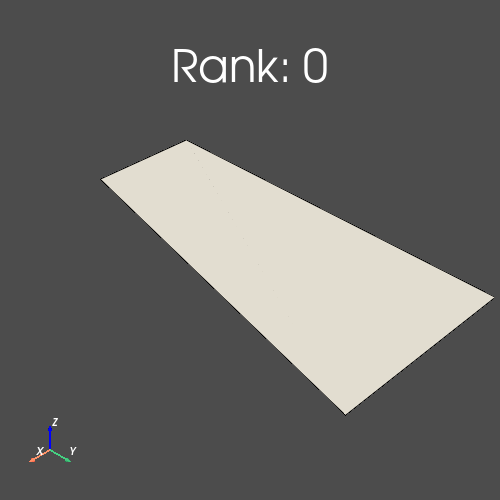

[output:1]

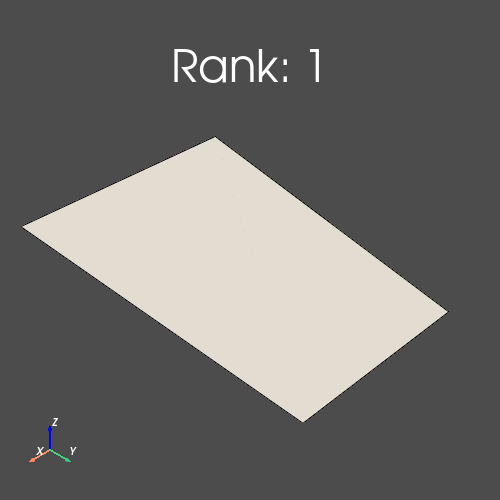

In [45]:
%%px
plot_mesh(quad_mesh)

## Custom partitioning

In some cases, one would like to use a specific partitioning. This might be because one have already partitioned the mesh, and when reading it in, one would like to keep this partitioning. We can achieve this by creating a custom partitioner.


In [ ]:
%%px


def custom_partitioner(comm: MPIpx.Intracomm, n, cell_types, topo):
    assert len(cell_types) == 1
    num_vertices = dolfinx.cpp.mesh.cell_num_vertices(cell_types[0])
    dests = np.full(int(len(topo[0]) / num_vertices), comm.rank, dtype=np.int32)
    offsets = np.arange(len(dests) + 1, dtype=np.int32)
    return dolfinx.graph.adjacencylist(dests, offsets)


custom_mesh = dolfinx.mesh.create_mesh(
    MPIpx.COMM_WORLD,
    quadrilaterals,
    quad_points,
    ufl_quad,
    partitioner=custom_partitioner,
)
num_cells_local = custom_mesh.topology.index_map(2).size_local
num_cells_global = custom_mesh.topology.index_map(2).size_global
print(
    f"Rank: {MPIpx.COMM_WORLD.rank}: {num_cells_local=} {num_cells_global=} (Num input cells: {quadrilaterals.shape[0]})"
)

[stdout:1] Rank: 1: num_cells_local=2 num_cells_global=2 (Num input cells: 2)


[stdout:0] Rank: 0: num_cells_local=0 num_cells_global=2 (Num input cells: 0)


[output:1]

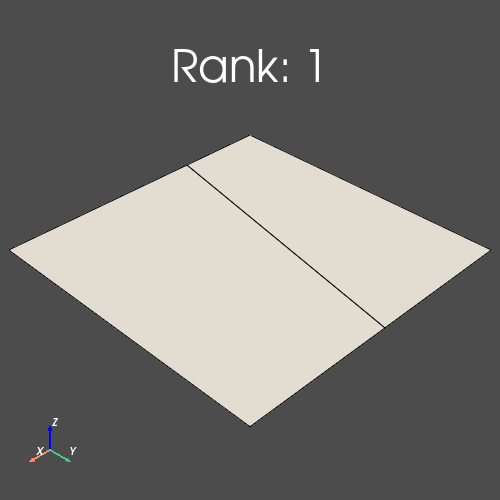

In [ ]:
%%px
pyvista.global_theme.allow_empty_mesh = True
plot_mesh(custom_mesh)

## Ghosting

If one wants to use Discontinuous Galerkin methods, one needs extra information in parallel.
To be able to compute interior integrals, every interior facet owned by a process needs to have access to the two cells its connected to.
To be able to control this, one can send in `ghost_mode=dolfinx.mesh.GhostMode.shared_facet` to the mesh creation algorithm.
We start by inspecting the previously created methods


In [48]:
%%px
print(f"Number of ghost cells: {cell_index_map.num_ghosts}")

[stdout:0] Number of ghost cells: 0


[stdout:1] Number of ghost cells: 0


Thus, we observe that we only have cells owned by the process on each rank. By adding ghost mode to the mesh creation:


In [ ]:
%%px
shared_partitioner = dolfinx.mesh.create_cell_partitioner(
    dolfinx.mesh.GhostMode.shared_facet
)
ghosted_mesh = dolfinx.mesh.create_mesh(
    MPIpx.COMM_WORLD,
    quadrilaterals,
    quad_points,
    ufl_quad,
    partitioner=shared_partitioner,
)
num_cells_local = ghosted_mesh.topology.index_map(ghosted_mesh.topology.dim).size_local
num_ghosts = ghosted_mesh.topology.index_map(ghosted_mesh.topology.dim).num_ghosts
print(f"{MPIpx.COMM_WORLD.rank}: {num_cells_local=} {num_ghosts=}")

[stdout:0] 0: num_cells_local=1 num_ghosts=1


[stdout:1] 1: num_cells_local=1 num_ghosts=1


## References

```{bibliography}
:filter: docname in docnames
```
